In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


In [2]:
print("Loading raw dataset...")

df = pd.read_csv("../data/Data_2.csv", header=None)

print("Shape:", df.shape)
df.head()


Loading raw dataset...
Shape: (11, 1)


,0
0,"Ticket_ID,Ticket_Type,Category,Priority,Create..."
1,"1001,Incident,Network,High,2024-01-05 10:15,20..."
2,"1002,Request,Software,Medium,2024/01/06 09:00,..."
3,"1003,Incident,Hardware,,2024-01-07 13:45,2024-..."
4,"1004,incident,Network,high,07-01-2024 15:30,07..."


In [3]:
df = df[0].str.split(",", expand=True)

df.columns = [
    "Ticket_ID", "Type", "Category", "Priority",
    "Created_Date", "Resolution_Date", "Assigned_To", "Description"
]

df.head()


,Ticket_ID,Type,Category,Priority,Created_Date,Resolution_Date,Assigned_To,Description
0,Ticket_ID,Ticket_Type,Category,Priority,Created_Date,Resolved_Date,Assigned_To,Description
1,1001,Incident,Network,High,2024-01-05 10:15,2024-01-05 14:30,John,Internet not working
2,1002,Request,Software,Medium,2024/01/06 09:00,2024/01/06 11:00,,Software installation needed
3,1003,Incident,Hardware,,2024-01-07 13:45,2024-01-07 16:00,Alice,Laptop overheating
4,1004,incident,Network,high,07-01-2024 15:30,07-01-2024 18:45,Bob,Slow network speed


In [4]:
df.info()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Ticket_ID        11 non-null     object
 1   Type             11 non-null     object
 2   Category         11 non-null     object
 3   Priority         11 non-null     object
 4   Created_Date     11 non-null     object
 5   Resolution_Date  11 non-null     object
 6   Assigned_To      11 non-null     object
 7   Description      11 non-null     object
dtypes: object(8)
memory usage: 836.0+ bytes


Ticket_ID          0
Type               0
Category           0
Priority           0
Created_Date       0
Resolution_Date    0
Assigned_To        0
Description        0
dtype: int64

In [5]:
priority_cleanup = {
    'low':'Low','medium':'Medium','high':'High',
    'urgent':'Critical','critical':'Critical','URGENT':'Critical'
}

df['Priority'] = df['Priority'].replace(priority_cleanup)

df['Priority'].value_counts()


Priority
High        3
Low         3
Medium      2
Priority    1
            1
Critical    1
Name: count, dtype: int64

In [6]:
text_cols = ['Type','Category','Priority','Assigned_To','Description']
df[text_cols] = df[text_cols].fillna("Unknown")

df.isnull().sum()


Ticket_ID          0
Type               0
Category           0
Priority           0
Created_Date       0
Resolution_Date    0
Assigned_To        0
Description        0
dtype: int64

In [8]:
df['Created_Date'] = pd.to_datetime(
    df['Created_Date'],
    format="%Y-%m-%d",
    errors='coerce'
)

df['Resolution_Date'] = df['Resolution_Date'].replace("not_resolved", pd.NaT)

df['Resolution_Date'] = pd.to_datetime(
    df['Resolution_Date'],
    format="%Y-%m-%d",
    errors='coerce'
)


In [9]:
df['Resolution_Duration'] = (
    df['Resolution_Date'] - df['Created_Date']
).dt.total_seconds()/3600

df['Resolution_Duration'] = df['Resolution_Duration'].fillna(-1)

priority_map = {'Low':1,'Medium':2,'High':3,'Critical':4}
df['Priority_Score'] = df['Priority'].map(priority_map).fillna(0)

df['Resolution_Status'] = np.where(
    df['Resolution_Duration']>=0,"Resolved","Unresolved"
)

df['Description_Length'] = df['Description'].str.len()

df.head()


,Ticket_ID,Type,Category,Priority,Created_Date,Resolution_Date,Assigned_To,Description,Resolution_Duration,Priority_Score,Resolution_Status,Description_Length
0,Ticket_ID,Ticket_Type,Category,Priority,NaT,NaT,Assigned_To,Description,-1.00,0.0,Unresolved,11
1,1001,Incident,Network,High,2024-01-05 10:15:00,2024-01-05 14:30:00,John,Internet not working,4.25,3.0,Resolved,20
2,1002,Request,Software,Medium,2024-01-06 09:00:00,2024-01-06 11:00:00,,Software installation needed,2.00,2.0,Resolved,28
3,1003,Incident,Hardware,,2024-01-07 13:45:00,2024-01-07 16:00:00,Alice,Laptop overheating,2.25,0.0,Resolved,18
4,1004,incident,Network,High,2024-07-01 15:30:00,2024-07-01 18:45:00,Bob,Slow network speed,3.25,3.0,Resolved,18


In [10]:
os.makedirs("../data", exist_ok=True)
df.to_csv("../data/Final_Cleaned_Data_2.csv", index=False)


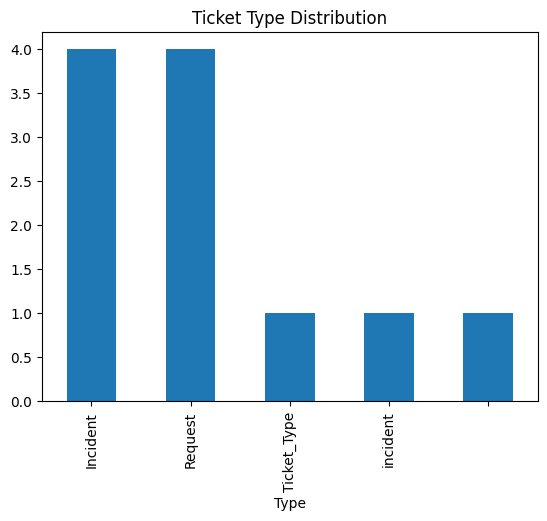

In [11]:
df['Type'].value_counts().plot(kind='bar')
plt.title("Ticket Type Distribution")
plt.show()


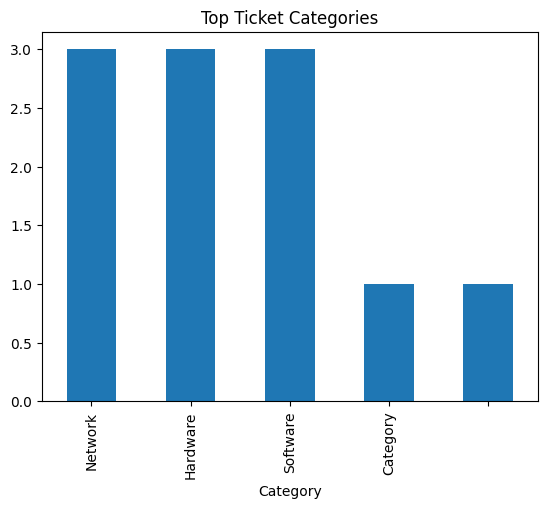

In [12]:
df['Category'].value_counts().head(10).plot(kind='bar')
plt.title("Top Ticket Categories")
plt.show()


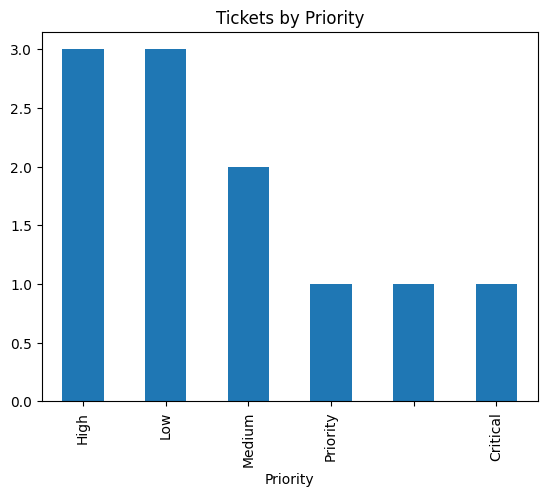

In [13]:
df['Priority'].value_counts().plot(kind='bar')
plt.title("Tickets by Priority")
plt.show()


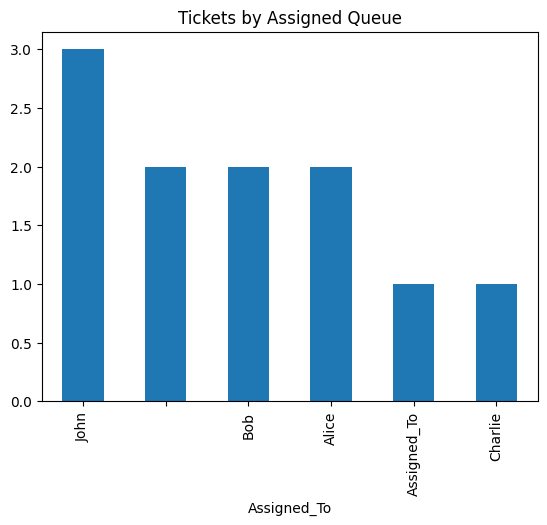

In [14]:
df['Assigned_To'].value_counts().head(10).plot(kind='bar')
plt.title("Tickets by Assigned Queue")
plt.show()


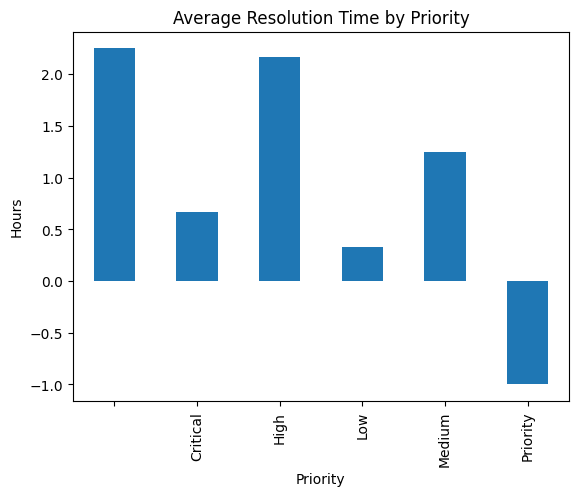

In [15]:
df.groupby('Priority')['Resolution_Duration'].mean().plot(kind='bar')
plt.title("Average Resolution Time by Priority")
plt.ylabel("Hours")
plt.show()


In [16]:
cluster_data = df[['Priority_Score','Resolution_Duration']].copy()

max_dur = cluster_data[cluster_data['Resolution_Duration']>=0]['Resolution_Duration'].max()

cluster_data['Resolution_Duration'] = cluster_data['Resolution_Duration'].replace(-1, max_dur+24)

kmeans = KMeans(n_clusters=3, random_state=42)

df['Cluster'] = kmeans.fit_predict(cluster_data)

df['Cluster'].value_counts()


Cluster
2    6
1    3
0    2
Name: count, dtype: int64

In [17]:
scaler = StandardScaler()

scaled = scaler.fit_transform(cluster_data)

centroids = scaler.transform(
    df.groupby('Cluster')[['Priority_Score','Resolution_Duration']].mean()
)

dist = [np.linalg.norm(scaled[i]-centroids[int(c)]) for i,c in enumerate(df['Cluster'])]

df['Similarity_Score'] = 1/(1+np.array(dist))

df.head()


,Ticket_ID,Type,Category,Priority,Created_Date,Resolution_Date,Assigned_To,Description,Resolution_Duration,Priority_Score,Resolution_Status,Description_Length,Cluster,Similarity_Score
0,Ticket_ID,Ticket_Type,Category,Priority,NaT,NaT,Assigned_To,Description,-1.00,0.0,Unresolved,11,1,0.270789
1,1001,Incident,Network,High,2024-01-05 10:15:00,2024-01-05 14:30:00,John,Internet not working,4.25,3.0,Resolved,20,0,0.959355
2,1002,Request,Software,Medium,2024-01-06 09:00:00,2024-01-06 11:00:00,,Software installation needed,2.00,2.0,Resolved,28,2,0.786725
3,1003,Incident,Hardware,,2024-01-07 13:45:00,2024-01-07 16:00:00,Alice,Laptop overheating,2.25,0.0,Resolved,18,2,0.431210
4,1004,incident,Network,High,2024-07-01 15:30:00,2024-07-01 18:45:00,Bob,Slow network speed,3.25,3.0,Resolved,18,0,0.959355


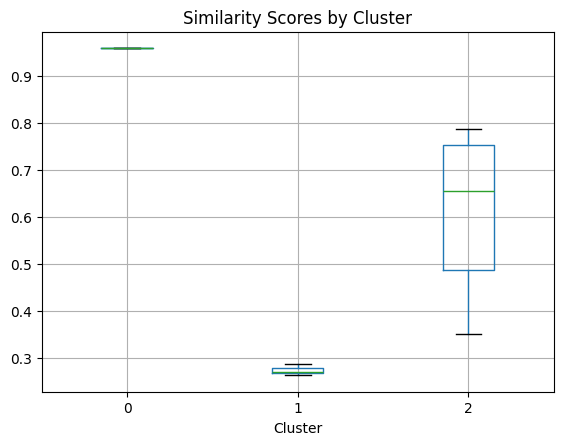

In [18]:
df.boxplot(column='Similarity_Score', by='Cluster')
plt.suptitle("")
plt.title("Similarity Scores by Cluster")
plt.show()


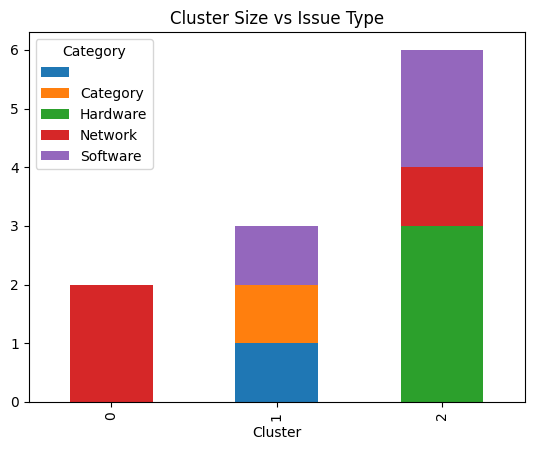

In [19]:
cluster_issue = pd.crosstab(df['Cluster'], df['Category'])

cluster_issue.plot(kind='bar', stacked=True)
plt.title("Cluster Size vs Issue Type")
plt.show()


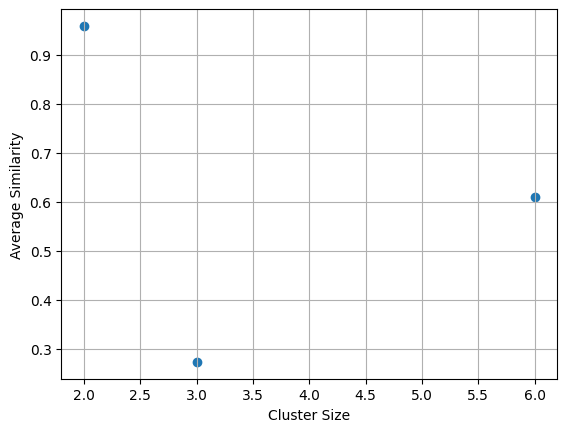

In [20]:
size = df.groupby('Cluster').size()
avg_sim = df.groupby('Cluster')['Similarity_Score'].mean()

plt.scatter(size, avg_sim)
plt.xlabel("Cluster Size")
plt.ylabel("Average Similarity")
plt.grid(True)
plt.show()


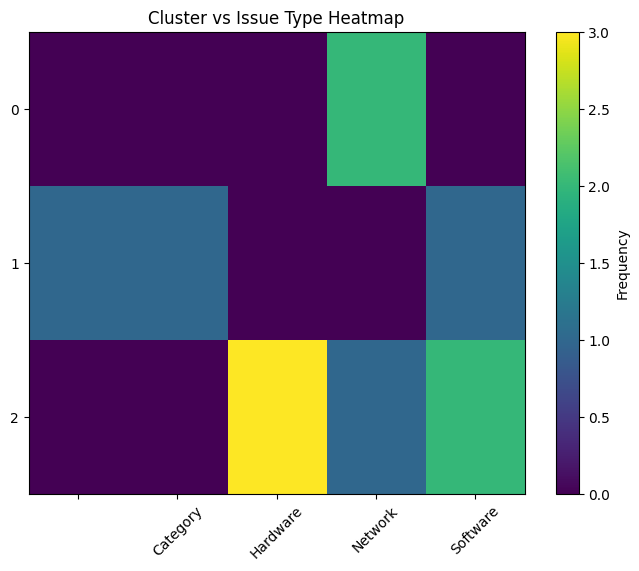

In [21]:
plt.figure(figsize=(8,6))
plt.imshow(cluster_issue.values, aspect='auto')
plt.colorbar(label="Frequency")

plt.xticks(range(len(cluster_issue.columns)), cluster_issue.columns, rotation=45)
plt.yticks(range(len(cluster_issue.index)), cluster_issue.index)

plt.title("Cluster vs Issue Type Heatmap")
plt.show()


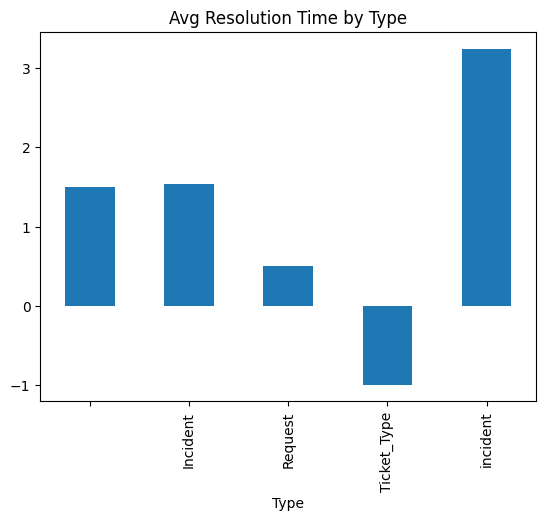

In [22]:
#Module 5

df.groupby('Type')['Resolution_Duration'].mean().plot(kind='bar')
plt.title("Avg Resolution Time by Type")
plt.show()


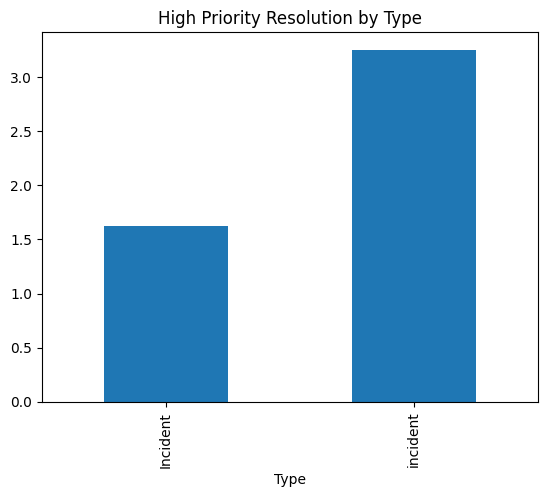

In [23]:
df[df['Priority']=='High'].groupby('Type')['Resolution_Duration'].mean().plot(kind='bar')
plt.title("High Priority Resolution by Type")
plt.show()


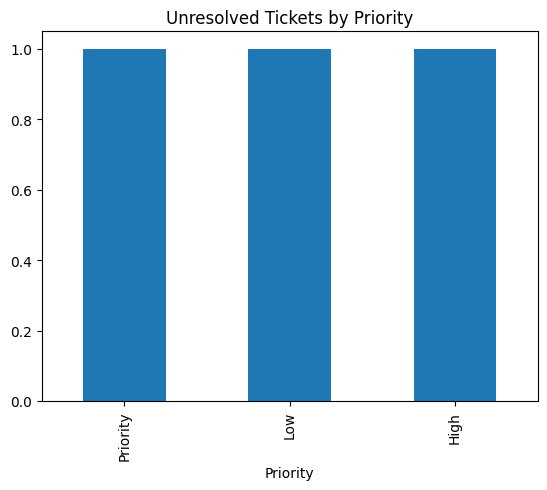

In [24]:
df[df['Resolution_Status']=="Unresolved"]['Priority'].value_counts().plot(kind='bar')
plt.title("Unresolved Tickets by Priority")
plt.show()


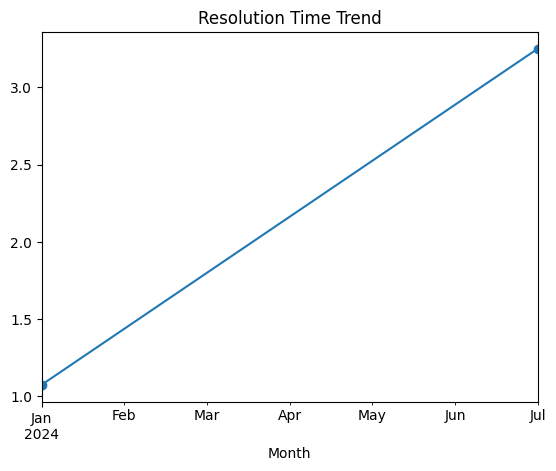

In [25]:
df['Month'] = df['Created_Date'].dt.to_period('M')

df.groupby('Month')['Resolution_Duration'].mean().plot(marker='o')
plt.title("Resolution Time Trend")
plt.show()


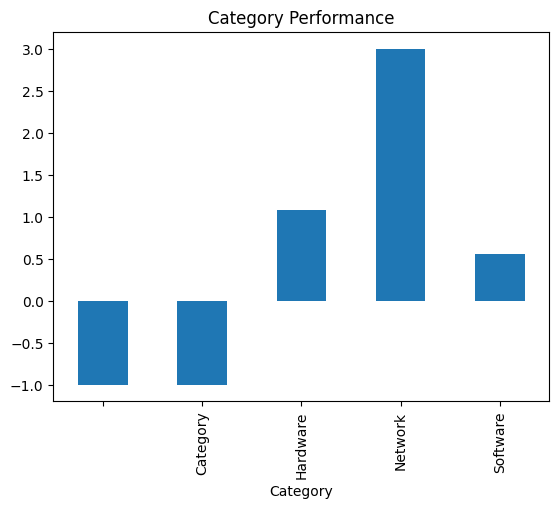

In [26]:
df.groupby('Category')['Resolution_Duration'].mean().head(10).plot(kind='bar')
plt.title("Category Performance")
plt.show()


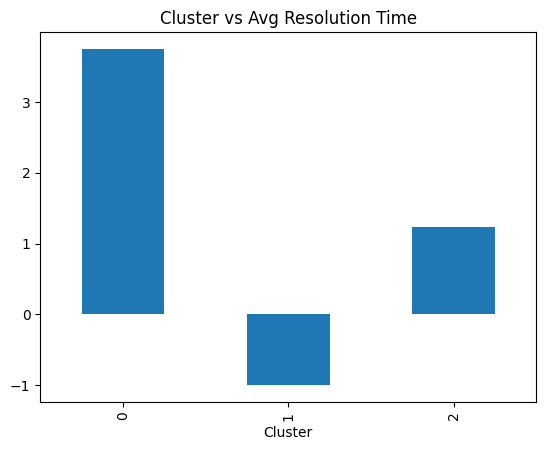

In [27]:
df.groupby('Cluster')['Resolution_Duration'].mean().plot(kind='bar')
plt.title("Cluster vs Avg Resolution Time")
plt.show()


In [31]:
print("Columns available:")
print(df.columns)


Columns available:
Index(['Ticket_ID', 'Type', 'Category', 'Priority', 'Created_Date',
       'Resolution_Date', 'Assigned_To', 'Description', 'Resolution_Duration',
       'Priority_Score', 'Resolution_Status', 'Description_Length', 'Cluster',
       'Similarity_Score', 'Month'],
      dtype='object')


In [33]:
#Module 6

if 'Country' in df.columns:
    region_col = 'Country'
elif 'Region' in df.columns:
    region_col = 'Region'
else:
    region_col = 'Assigned_To'   # fallback (recommended)

print("Using column for regional analysis:", region_col)


Using column for regional analysis: Assigned_To


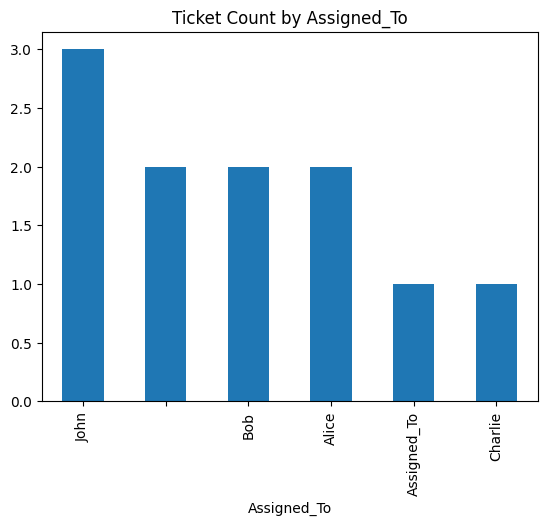

In [34]:
ticket_count = df[region_col].value_counts()

ticket_count.plot(kind='bar')
plt.title(f"Ticket Count by {region_col}")
plt.show()


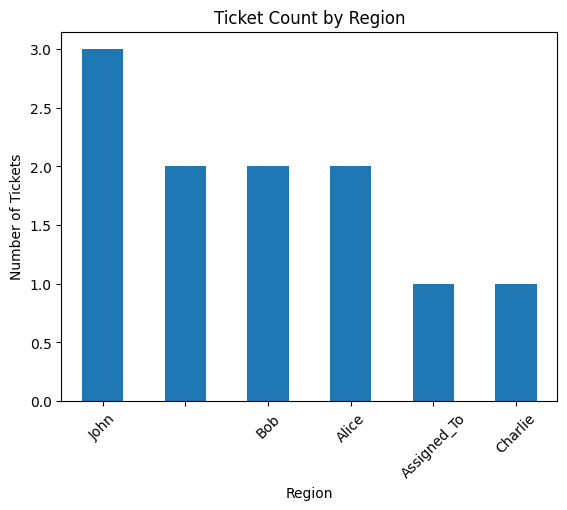

In [35]:
ticket_count.plot(kind='bar')
plt.title("Ticket Count by Region")
plt.xlabel("Region")
plt.ylabel("Number of Tickets")
plt.xticks(rotation=45)
plt.show()


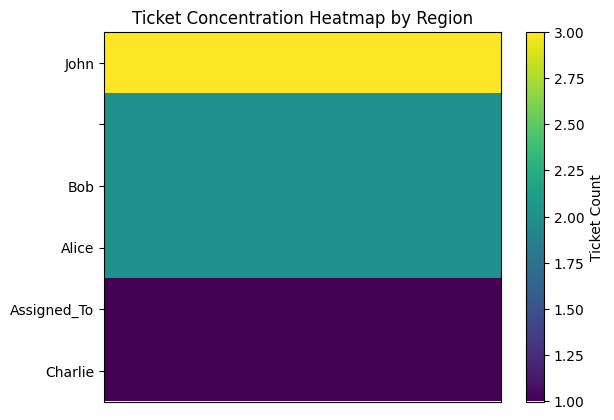

In [36]:
heat_data = ticket_count.values.reshape(-1, 1)

plt.imshow(heat_data, aspect='auto')
plt.colorbar(label='Ticket Count')

plt.yticks(range(len(ticket_count.index)), ticket_count.index)
plt.xticks([])

plt.title("Ticket Concentration Heatmap by Region")
plt.show()


In [37]:
region_category = pd.crosstab(df[region_col], df['Category'])

region_category.head()


Category,,Category,Hardware,Network,Software
Assigned_To,,,,,
,0,0,1,0,1
Alice,0,0,2,0,0
Assigned_To,0,1,0,0,0
Bob,0,0,0,2,0
Charlie,1,0,0,0,0


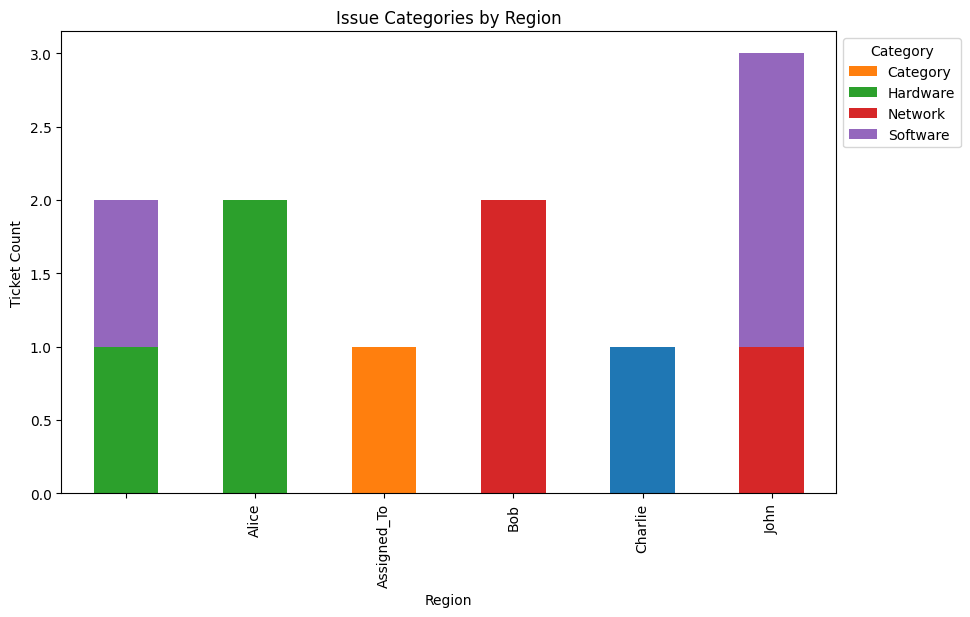

In [38]:
region_category.plot(kind='bar', stacked=True, figsize=(10,6))
plt.title("Issue Categories by Region")
plt.xlabel("Region")
plt.ylabel("Ticket Count")
plt.legend(title="Category", bbox_to_anchor=(1,1))
plt.show()


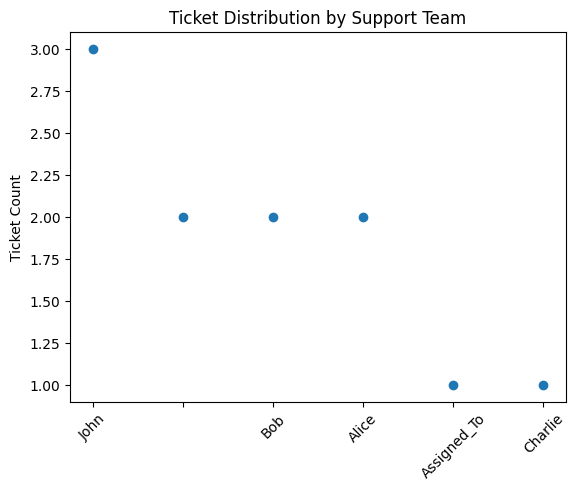

In [40]:
team_counts = df['Assigned_To'].value_counts()

plt.scatter(range(len(team_counts)), team_counts)

plt.xticks(range(len(team_counts)), team_counts.index, rotation=45)
plt.ylabel("Ticket Count")
plt.title("Ticket Distribution by Support Team")

plt.show()


In [41]:
region_perf = df.groupby(region_col)['Resolution_Duration'].mean()

region_perf


Assigned_To
               1.250000
Alice          1.375000
Assigned_To   -1.000000
Bob            2.375000
Charlie       -1.000000
John           1.305556
Name: Resolution_Duration, dtype: float64

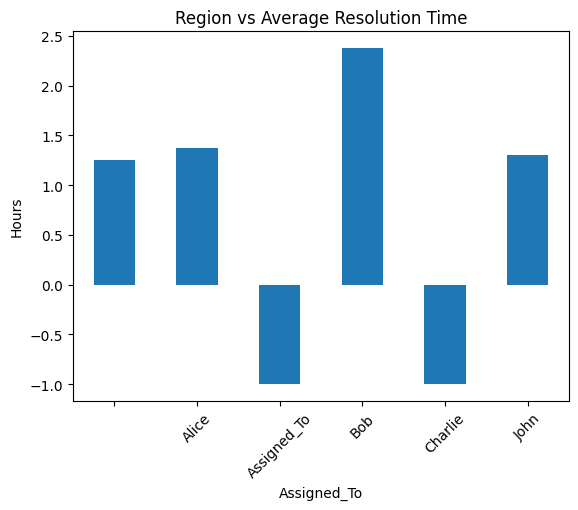

In [42]:
region_perf.plot(kind='bar')
plt.title("Region vs Average Resolution Time")
plt.ylabel("Hours")
plt.xticks(rotation=45)
plt.show()


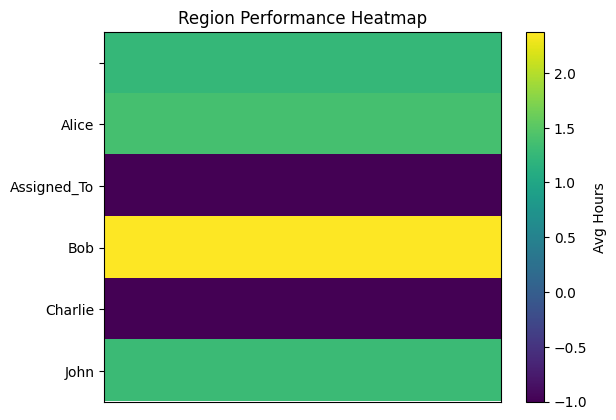

In [43]:
heat_data = region_perf.values.reshape(-1, 1)

plt.imshow(heat_data, aspect='auto')
plt.colorbar(label='Avg Hours')

plt.yticks(range(len(region_perf.index)), region_perf.index)
plt.xticks([])

plt.title("Region Performance Heatmap")
plt.show()


In [44]:
cluster_size = df.groupby('Cluster').size()

cluster_size


Cluster
0    2
1    3
2    6
dtype: int64

In [45]:
cluster_perf = df.groupby('Cluster')['Resolution_Duration'].mean()

cluster_perf


Cluster
0    3.750000
1   -1.000000
2    1.236111
Name: Resolution_Duration, dtype: float64

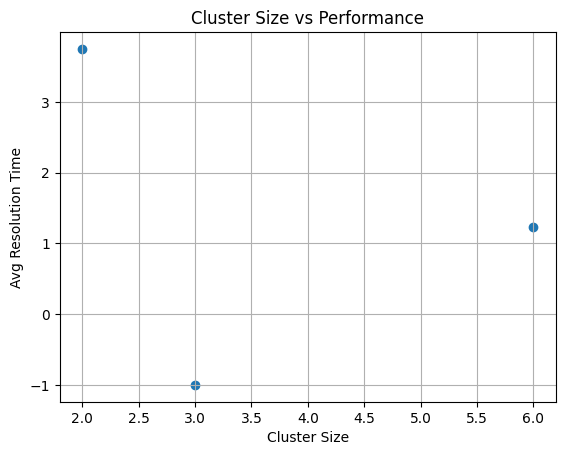

In [46]:
plt.scatter(cluster_size, cluster_perf)

plt.xlabel("Cluster Size")
plt.ylabel("Avg Resolution Time")
plt.title("Cluster Size vs Performance")
plt.grid(True)
plt.show()


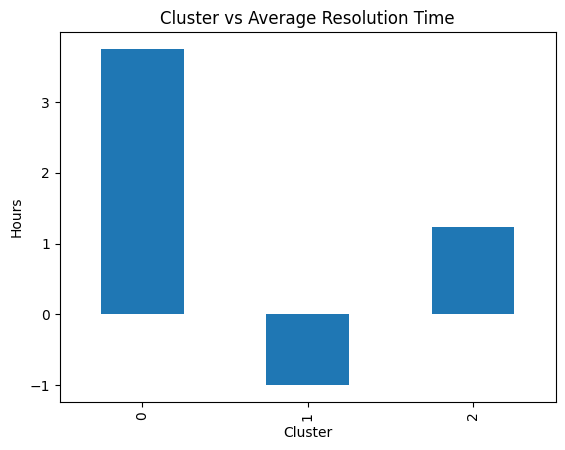

In [47]:
cluster_perf.plot(kind='bar')

plt.title("Cluster vs Average Resolution Time")
plt.ylabel("Hours")
plt.show()


In [48]:
summary = pd.DataFrame({
    "Cluster_Size": cluster_size,
    "Avg_Resolution_Time": cluster_perf
})

summary


,Cluster_Size,Avg_Resolution_Time
Cluster,,
0,2,3.750000
1,3,-1.000000
2,6,1.236111
